# Oh Boy, Here I Go Analyzing Data Again
***

### Dataset Description
The principal dataset we're exploring is the Chicago CLEAR(Citizen Law Enforcement Analysis and Reporting) database. There are 22 total attributes in the original dataset. Note that each record is of a single crime irregardless of when it was committed so multiple rows can refer to the same incident. Also note that to protect the privacy of victims the location data is shifted but is accurate to the block.   

* **ID** unique integer identifier for the crime record.
* **Case Number** The Chicago Police Department RD Number (Records Division Number), which is unique to each incident.
* **Date** Date when incident occurred.
* **Block** The address where the incident occurred.
* **IUCR** The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description.
* **Primary Type** The primary description of the IUCR code.
* **Description** The secondary description of the IUCR code, a subcategory of the primary description.
* **Location Description** Description of the location where the incident occurred.
* **Arrest** Indicates whether an arrest was made.
* **Domestic** Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
* **Beat** Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts.
* **District** Indicates the police district where the incident occurred.
* **Ward** The ward (City Council district) where the incident occurred.
* **Community Area** Indicates the community area where the incident occurred. Chicago has 77 community areas.
* **FBI Code** Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS)
* **X Coordinate** The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 
* **Y Coordinate** The y coordinate of the location where the incident occurred.
* **Year** Year when incident occurred.
* **Updated On** Date and time the record was last updated.
* **Latitude** The latitude of the location where the incident occurred.
* **Longitude** The longitude of the location where the incident occurred. 
* **Location**  The combination of latitude and longitude.

*Descriptions of attributes taken from 
[data.cityofchicago.org](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present-Dashboard/5cd6-ry5g)*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

## Data Preprocessing
***
### Parsing the CSV
**Datetimes:** The *Date* attribute follows the U.S. "month/day/year hour:minute:second period" date and time format. This column will be converted into datetime objects during intial parsing.

**Locations:** In order to protect the individuals involved the location data of incidents are partial redacted and are only accurate to the block, therefore the  *Block, X Coordinate, Y Coordinate* columns are ignored during intial parsing. *Latitude and Longitude* are chosen over *Block* because the numerical values are easier to parse than arbitrary address names.

**Redundancy:** The *IUCR, Year, and Location* attributes all repeat information available in the other columns and therefore are ignored during intial parsing.

**Usefulness:** The *Updated On* attribute is not relevent to the type of information we're looking for and is ignored during initial parsing.

In [2]:
dateparse = lambda t: pd.to_datetime(t, format="%m/%d/%Y %H:%M:%S %p")

types = {"Primary Type":"category","Description":"category",
         "Location Description":"category", "Beat":"category", "Ward":"category",
         "Community Area":"category", "District":"category", "FBI Code":"category"}

columns = list(types.keys())+["ID","Date","Arrest","Domestic","Case Number","Latitude","Longitude"]

dfCrime = pd.read_csv(
    "Samples/RandomCrime.csv",
    parse_dates=["Date"],
    date_parser=dateparse,
    usecols = columns,
    dtype = types,
    index_col = 0
)

#TODO - Should some location categories be removed? Beat, District, Ward, and Community Area might be redundant

### Null Values

In [3]:
dfCrime.isnull().sum()

Case Number                 0
Date                        0
Primary Type                0
Description                 0
Location Description       55
Arrest                      0
Domestic                    0
Beat                        0
District                    2
Ward                    12238
Community Area          12266
FBI Code                    0
Latitude                 1888
Longitude                1888
dtype: int64

The *Location Description, Ward, Community Area, Latitude, and Longitude* attributes all contain explicitly null values. Given that we're attempting geo-spatial analysis and there's no sensible way to fill in incomplete location data, tuples with missing values will be ignored.

In [4]:
dfCrime.dropna(inplace=True)
#TODO - Confirm that there are no implicitly null values (like 999 or 0 representing missing values)

### Outliers

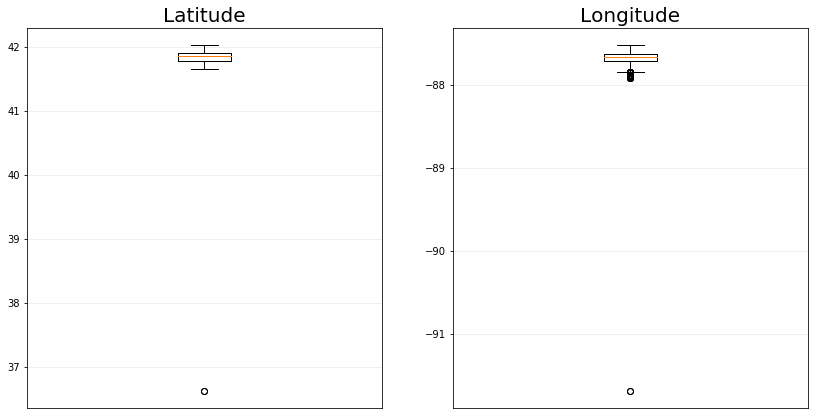

In [5]:
def locationBoxPlot():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

    axes[0].boxplot(dfCrime["Latitude"])
    axes[0].set_title("Latitude", fontsize=20)
    axes[0].set_xticks([])
    axes[0].grid(alpha=0.25)
    axes[0].set_axisbelow(True)

    axes[1].boxplot(dfCrime["Longitude"])
    axes[1].set_title("Longitude", fontsize=20)
    axes[1].set_xticks([])
    axes[1].grid(alpha=0.25)
    axes[1].set_axisbelow(True)
    
locationBoxPlot()

Clearly there's at least one point that doesn't belong. While longitude seemingly has a lot of outliers the only ones that will be removed are those outside the coordinates of the city boundaries. 

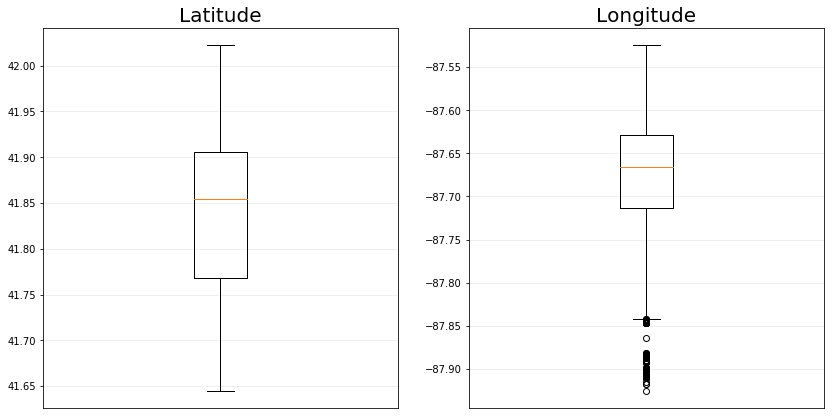

In [6]:
dfCrime = dfCrime.loc[dfCrime["Latitude"] > 41.6].loc[dfCrime["Latitude"] < 42.1]
dfCrime = dfCrime.loc[dfCrime["Longitude"] > -88].loc[dfCrime["Longitude"] < -87.5]

locationBoxPlot()

## A Quick Look
***

### Dates

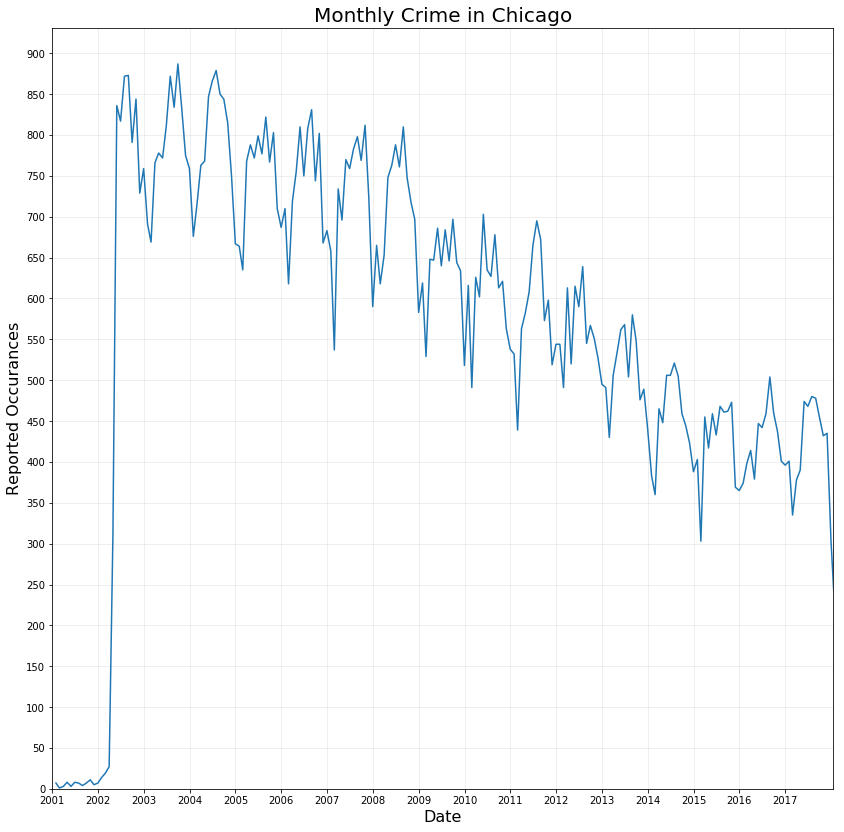

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,14))
ax.plot(dfCrime.groupby(pd.Grouper(key="Date",freq='M'))["Date"].count())

ax.set_xlabel("Date", fontsize=16)
ax.set_xlim(["2001",dfCrime["Date"].max()])
ax.set_xticks([str(year) for year in range(2001,2018)])

ax.set_ylabel("Reported Occurances", fontsize=16)
ymin, ymax = ax.get_ylim()
ax.set_ylim([0, ymax])
ax.set_yticks(range(0, int(ymax),50))

ax.grid(alpha=0.25)
ax.set_title("Monthly Crime in Chicago", fontsize=20)
ax.set_axisbelow(True)